# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
pip install --upgrade category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
#from sklearn.preprocessing import CategoricalEncoder
import category_encoders as ce
import time 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data_0 = len(data)
data_0 

354369

По предварительной информации мы можем сразу заметить несколько вещей:
1. размер данных очень большой - 354000 строк. это уже говорит нам о том, что в будущем, скорость работы кода - будет важна, а так же о том, что код должен быть более менее универсальным для простого редактирования в будущем.
2. несколько столбцов с датами - к ним стоит присмотреться и понять, какие нам нужны, а какие на обучение не повлияют 

посмотрим в количесвенном составе и процентном соотношении наличие пропусков

In [7]:
display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm'))

data_isnull = data.isnull().sum()
display(data_isnull)
data.duplicated().sum()

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

4

удаляем эти 4 дубликата)

In [8]:
data = data.drop_duplicates()
data.duplicated().sum()

0

в 5 столбцах присутсвуют пропуски, но прежде чем их удалять/заполнять, посмотрим на уникальыне значения в каждом из столбоцв

In [9]:
data_isnull = data_isnull.index[data_isnull>0].tolist()

In [10]:

for i in data_isnull:
    print (i)
    print()
    display(data[i].value_counts())
    display(data[i].unique())
    print("\n")

VehicleType



sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)



Gearbox



manual    268249
auto       66283
Name: Gearbox, dtype: int64

array(['manual', 'auto', nan], dtype=object)



Model



golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'



FuelType



petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)



Repaired



no     247158
yes     36053
Name: Repaired, dtype: int64

array([nan, 'yes', 'no'], dtype=object)

в трех столбцах `FuelType`,`Gearbox` и `Model` пропусков меньше 10%, значения мы так же не сможем подобрать, поэтому удаляем строки с пропусками в этих столбцах

In [11]:
data = data.dropna(subset=['Gearbox','Model','FuelType'])
data = data.reset_index(drop=True)
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
2,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
3,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
4,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299219,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
299220,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
299221,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
299222,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


в столбце  `Repaired` много пропусков, и мы никак не сможем подобрать значения, поэтому поменяем пропуски на значение `Unknown`

In [12]:
data['Repaired'] = data['Repaired'].fillna('Unknown')
display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm'))

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,5.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,0.000000


остался столбец `VehicleType`. Пропуски в нем мы заполним, ориентируясь на столбец `Model`: создаем список самых часто встречающихся кузовов у определенной модели, и по нему заполняем пропуски


In [13]:
data['VehicleType'] = data['VehicleType'].fillna(
                      data.groupby('Model')['VehicleType'].transform(
                      lambda x: x.mode()[0] if not x.mode().empty
                         else np.nan))


In [14]:
display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm'))

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,0.000000


все пропуски и дубликаты устранены

првоерим датасет на выбросы

array([[<AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'RegistrationYear'}>,
        <AxesSubplot:title={'center':'Power'}>],
       [<AxesSubplot:title={'center':'Kilometer'}>,
        <AxesSubplot:title={'center':'RegistrationMonth'}>,
        <AxesSubplot:title={'center':'NumberOfPictures'}>],
       [<AxesSubplot:title={'center':'PostalCode'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

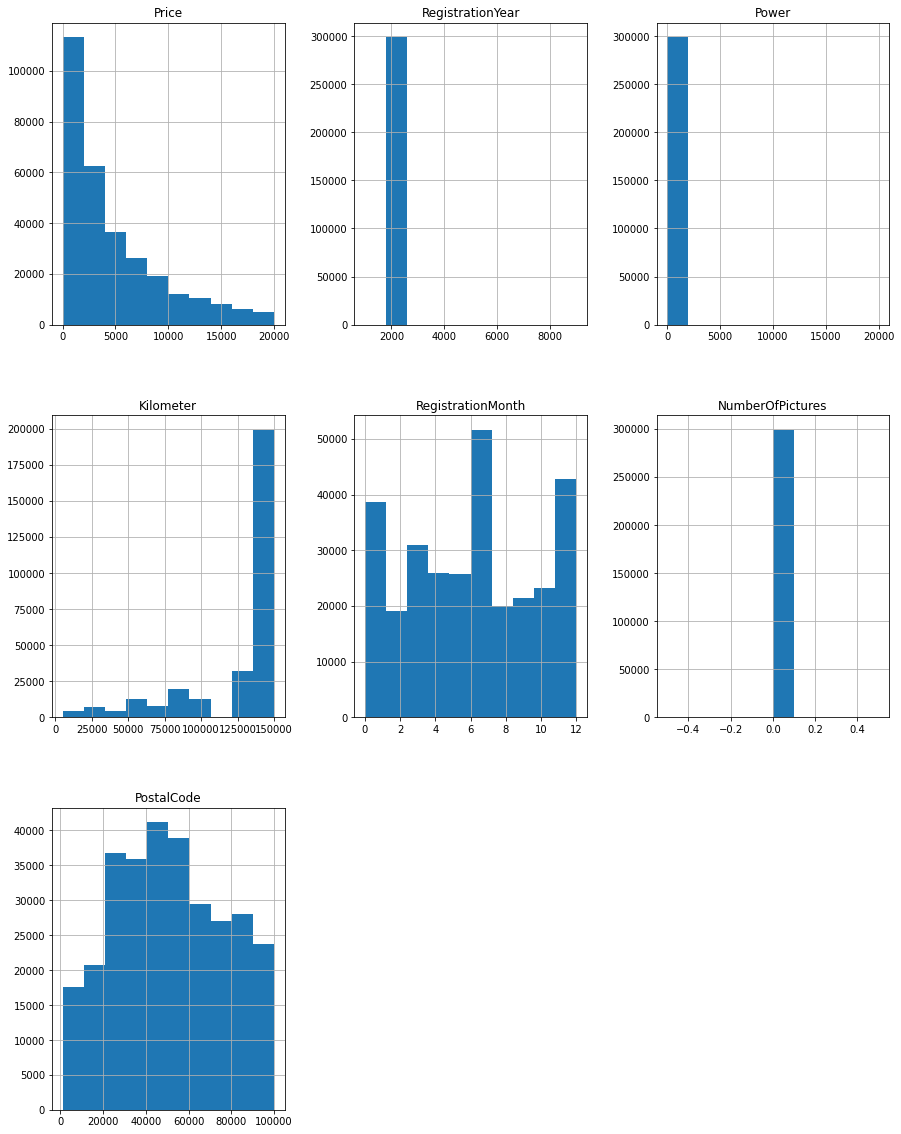

In [15]:
data.hist(figsize=(15, 20))

### выбросы в  RegistrationYear

In [16]:
data['RegistrationYear'].describe()

count    299224.000000
mean       2003.206919
std          24.504343
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9000.000000
Name: RegistrationYear, dtype: float64

сразу видим аномально большие и аномально маленькие значения в в датасете
1. практически весь столбец находиться в приделал от 1999 до 2007, поэтому выбросы мы просто удаляем
2. поставим временые рамки : от 1950 года до 2017 года

count    292099.000000
mean       2002.759739
std           6.349659
min        1951.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


<AxesSubplot:>

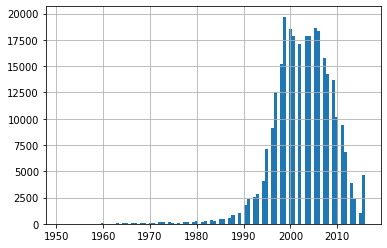

In [17]:
data['RegistrationYear'] = data.loc[(data['RegistrationYear']<2017,'RegistrationYear')]
data['RegistrationYear'] = data.loc[(data['RegistrationYear']>1950,'RegistrationYear')]
print(data['RegistrationYear'].describe())
data['RegistrationYear'].hist(bins = 100)


### выбросы в  Price

count    299224.000000
mean       4743.299859
std        4604.430669
min           0.000000
25%        1250.000000
50%        3000.000000
75%        6900.000000
max       20000.000000
Name: Price, dtype: float64


<AxesSubplot:>

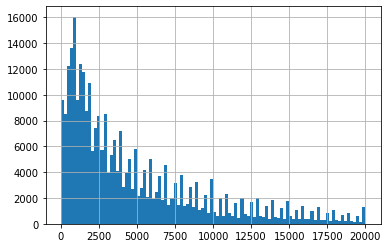

In [18]:
print(data['Price'].describe())
data['Price'].hist(bins = 100)

цена равная 0 вызывает подозрение, однако сложно назвать это выбросами




<AxesSubplot:>

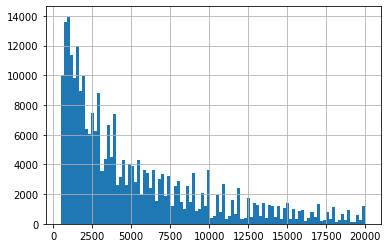

In [19]:
data['Price'] = data.loc[(data['Price']>500,'Price')]
data['Price'].hist(bins = 100)

попробовал сделать разумный фильтр, где минимальная стоимость авто - 500 евро

### выбросы в  Power

count    299224.000000
mean        115.846556
std         172.614475
min           0.000000
25%          75.000000
50%         108.000000
75%         144.000000
max       20000.000000
Name: Power, dtype: float64


<AxesSubplot:>

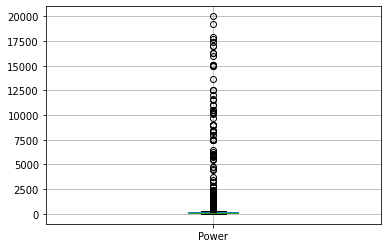

In [20]:
print(data['Power'].describe())
data.boxplot(column=['Power'])

выберем порог в 250 л.с. сверху и 50 л.с. снизу

<AxesSubplot:>

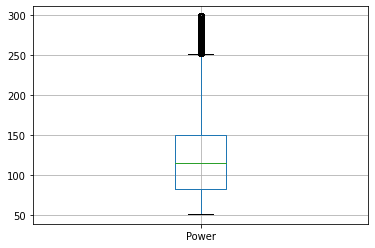

In [21]:
data['Power'] = data.loc[(data['Power']<300,'Power')]
data['Power'] = data.loc[(data['Power']>50,'Power')]
data.boxplot(column=['Power'])

### выбросы в  Kilometer

count    299224.000000
mean     128490.361736
std       36696.612311
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


<AxesSubplot:>

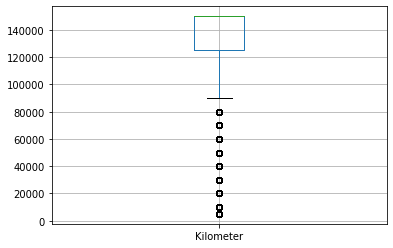

In [22]:
print(data['Kilometer'].describe())
data.boxplot(column=['Kilometer'])

выбросов в данном столбце не обнаружено

проверяем данные еще раз на наличие пропусков

In [23]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299224 entries, 0 to 299223
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DateCrawled        299224 non-null  object 
 1   Price              272557 non-null  float64
 2   VehicleType        299224 non-null  object 
 3   RegistrationYear   292099 non-null  float64
 4   Gearbox            299224 non-null  object 
 5   Power              267625 non-null  float64
 6   Model              299224 non-null  object 
 7   Kilometer          299224 non-null  int64  
 8   RegistrationMonth  299224 non-null  int64  
 9   FuelType           299224 non-null  object 
 10  Brand              299224 non-null  object 
 11  Repaired           299224 non-null  object 
 12  DateCreated        299224 non-null  object 
 13  NumberOfPictures   299224 non-null  int64  
 14  PostalCode         299224 non-null  int64  
 15  LastSeen           299224 non-null  object 
dtypes:

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,NaN,sedan,1993.0,manual,NaN,golf,150000,0,petrol,volkswagen,Unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-14 12:52:21,9800.0,suv,2004.0,auto,163.0,grand,125000,8,gasoline,jeep,Unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
2,2016-03-17 16:54:04,1500.0,small,2001.0,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
3,2016-03-31 17:25:20,3600.0,small,2008.0,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
4,2016-04-04 17:36:23,650.0,sedan,1995.0,manual,102.0,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [24]:
display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm'))
data = data.dropna(subset=['RegistrationYear','Power','Price'])
data = data.reset_index(drop=True)
display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm'))

,0
DateCrawled,0.000000
Price,9.000000
VehicleType,0.000000
RegistrationYear,2.000000
Gearbox,0.000000
Power,11.000000
Model,0.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,0.000000


,0
DateCrawled,0.000000
Price,0.000000
VehicleType,0.000000
RegistrationYear,0.000000
Gearbox,0.000000
Power,0.000000
Model,0.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,0.000000


In [25]:
losses = 1 -(len(data)/data_0)
print("{:.0%}".format(losses))

31%


31% данных потеряли при обработке пропусков

изначально это были 36%, однако подвинув некоторые пороговые значения получилось сократить до 31%

### подготовка данных к обучению модели 

удалим ненужные столбцы

In [26]:
data_1 = data.drop(['DateCrawled','DateCreated','PostalCode','LastSeen','NumberOfPictures','RegistrationMonth'], axis=1)
data_1.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,9800.0,suv,2004.0,auto,163.0,grand,125000,gasoline,jeep,Unknown
1,1500.0,small,2001.0,manual,75.0,golf,150000,petrol,volkswagen,no
2,3600.0,small,2008.0,manual,69.0,fabia,90000,gasoline,skoda,no
3,650.0,sedan,1995.0,manual,102.0,3er,150000,petrol,bmw,yes
4,2200.0,convertible,2004.0,manual,109.0,2_reihe,150000,petrol,peugeot,no


воспользуемся методом Mean Encoding


<div class="alert alert-light" role="alert">
  на самом деле я не понял как после Mean Encoding на треноровочной выборке эти же значения засунуть в тестовую и валидационную(я понимаю что мы должны имитировать реальный процесс, когда "тестовая" является поступающей "здесь и сейчась" информацией) поэтому решил сократить для себя время. если подскажешь, буду благодарен
</div>

разобъем данные на признаки и целевой признак

In [32]:
features = data_1.drop(['Price'], axis=1)
target = data_1['Price']

In [33]:

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=123)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=123)

обучим и трансформируем признаки методом Mean Encoding

In [34]:
Mean_encoding = ce.m_estimate.MEstimateEncoder(cols=['Brand','Model','VehicleType','Gearbox','FuelType','Repaired'])

features_train_encoded = Mean_encoding.fit_transform(features_train,target_train)
features_valid_encoded = Mean_encoding.transform(features_valid)
features_test_encoded = Mean_encoding.transform(features_test)

features_train_encoded

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
77103,5212.155641,2006.0,4800.832716,90.0,5005.850445,150000,7090.570332,5493.514989,5785.299929
120525,7136.310052,2015.0,4800.832716,69.0,8329.137404,5000,4428.378552,3459.507085,5785.299929
16917,5514.239960,2001.0,7375.786671,170.0,5973.898800,150000,7090.570332,6352.645935,3818.737946
142119,3501.741541,1998.0,4800.832716,53.0,1984.465429,150000,4428.378552,2984.742025,3818.737946
52391,5514.239960,2001.0,4800.832716,75.0,4023.670473,150000,7090.570332,4106.228261,3818.737946
...,...,...,...,...,...,...,...,...,...
119906,3501.741541,2007.0,4800.832716,60.0,3627.946466,90000,4428.378552,4106.228261,5785.299929
192476,5212.155641,1992.0,4800.832716,133.0,1868.420424,150000,4428.378552,7023.938373,5785.299929
17730,3501.741541,2004.0,7375.786671,125.0,3885.207434,40000,4428.378552,6352.645935,5785.299929
28030,5212.155641,2016.0,4800.832716,105.0,5594.128277,150000,4428.378552,6828.384574,3818.737946


In [35]:
num_features = ['RegistrationYear','Power','Kilometer','VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

In [36]:
features_train_scaled = features_train_encoded.copy()
features_valid_scaled = features_valid_encoded.copy()
features_test_scaled = features_test_encoded.copy()

scaler = StandardScaler()
scaler.fit(features_train_encoded[num_features])

features_train_scaled[num_features] = scaler.transform(features_train_scaled[num_features])
features_valid_scaled[num_features] = scaler.transform(features_valid_scaled[num_features])
features_test_scaled[num_features] = scaler.transform(features_test_scaled[num_features])

features_train_scaled

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
77103,-0.095084,0.429620,-0.512343,-0.706748,-0.140298,0.614514,1.373889,0.112852,0.468316
120525,1.379984,1.944695,-0.512343,-1.149646,1.277547,-3.307639,-0.710907,-1.347116,0.468316
16917,0.136495,-0.412089,1.951819,0.980484,0.272710,0.614514,1.373889,0.729519,-1.582602
142119,-1.406298,-0.917114,-0.512343,-1.487092,-1.429339,0.614514,-0.710907,-1.687893,-1.582602
52391,0.136495,-0.412089,-0.512343,-1.023104,-0.559334,0.614514,1.373889,-0.882913,-1.582602
...,...,...,...,...,...,...,...,...,...
119906,-1.406298,0.597961,-0.512343,-1.339460,-0.728166,-1.008446,-0.710907,-0.882913,0.468316
192476,-0.095084,-1.927163,-0.512343,0.200139,-1.478849,0.614514,-0.710907,1.211359,0.468316
17730,-1.406298,0.092936,1.951819,0.031416,-0.618408,-2.360912,-0.710907,0.729519,0.468316
28030,-0.095084,2.113036,-0.512343,-0.390392,0.110685,0.614514,-0.710907,1.070994,-1.582602


в первой части проекта было выполнено:

1. изучение таблицы с данными
2. удаление или заменена пропуков
3. устранение аномальных значений 
4. удаление лишних столбцов перед обучением
5. Разделение выборки на тренировочную, валидационную и тестовую
6. масштабирование данных
7. Обработка категориальных признаков техниками Mean Encoding 


## Обучение моделей

### DecisionTreeRegressor 

In [40]:
%%time

DTR = DecisionTreeRegressor(random_state=123)
PAR_DTR = {'max_depth':  [x for x in range(1, 7)],
           'min_samples_leaf' : [x for x in range (1, 5)]}

DTR_MODEL = GridSearchCV(DTR,PAR_DTR,cv=5, scoring ='neg_mean_squared_error')
DTR_MODEL.fit(features_train_scaled,target_train)

print("лучшие параметры",DTR_MODEL.best_params_)


лучшие параметры {'max_depth': 6, 'min_samples_leaf': 1}
CPU times: user 10.3 s, sys: 31.5 ms, total: 10.3 s
Wall time: 10.3 s


In [41]:
%%time
start = time.time()
model = DecisionTreeRegressor(random_state=123,max_depth= 6, min_samples_leaf = 1)
model.fit(features_train_scaled,target_train)
end = time.time()
time_DTR_fit =(end - start)
time_DTR_fit

CPU times: user 154 ms, sys: 0 ns, total: 154 ms
Wall time: 164 ms


0.16365599632263184

In [42]:
%%time
start = time.time()

predictions_Tree = model.predict(features_valid_scaled)
DTR_RMSE = sqrt(mean_squared_error(target_valid, predictions_Tree))

end = time.time()
time_DTR_pred =(end - start)

print(time_DTR_pred)
print(DTR_RMSE)

0.006658792495727539
2210.9789541794466
CPU times: user 7.66 ms, sys: 0 ns, total: 7.66 ms
Wall time: 6.82 ms


### CatBoostRegressor 

In [46]:
cat_features = list(features.columns)
cat_features 

['VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'Repaired']

In [47]:
%%time
start = time.time()
model_cat = CatBoostRegressor(iterations=40,depth = 6)
model_cat.fit(features_train_scaled, target_train, verbose=10)
end = time.time()
time_cat_fit =(end - start)
time_cat_fit

Learning rate set to 0.5
0:	learn: 3193.7743025	total: 73.9ms	remaining: 2.88s
10:	learn: 1813.1848357	total: 274ms	remaining: 723ms
20:	learn: 1725.5527644	total: 496ms	remaining: 449ms
30:	learn: 1675.4609384	total: 701ms	remaining: 203ms
39:	learn: 1644.6974504	total: 859ms	remaining: 0us
CPU times: user 876 ms, sys: 28.5 ms, total: 904 ms
Wall time: 1.65 s


1.6537079811096191

In [48]:
%%time
start = time.time()
predictions_Cat = model_cat.predict(features_valid_scaled)
CBR_RMSE = sqrt(mean_squared_error(target_valid, predictions_Cat))
end = time.time()
time_cat_pred =(end - start)

print(CBR_RMSE)

1675.2235988883747
CPU times: user 13.6 ms, sys: 95 µs, total: 13.7 ms
Wall time: 12.4 ms


### LGBMRegressor 

In [49]:
%%time
start = time.time()

model_LGBMR = LGBMRegressor(learning_rate=0.1, num_leaves=200, random_state=123)
model_LGBMR.fit(features_train_scaled, target_train)

end = time.time()
time_LGBMR_fit =(end - start)
time_LGBMR_fit

CPU times: user 23min 4s, sys: 18.9 s, total: 23min 23s
Wall time: 23min 35s


1415.463531255722

In [50]:
%%time
start = time.time()

predictions_LGBMR = model_LGBMR.predict(features_valid_scaled)
LGBMR_RMSE = sqrt(mean_squared_error(target_valid, predictions_LGBMR))

end = time.time()
time_LGBMR_pred =(end - start)

print(LGBMR_RMSE)

1512.438156019807
CPU times: user 553 ms, sys: 6.01 ms, total: 559 ms
Wall time: 596 ms


было опробировано три модели:

1. DecisionTreeRegressor
2. CatBoostRegressor
3. LGBMRegressor

самым быстрым получилось дерево решений, однако качество оставляет жедать лучшего

LGBM напротив - оказалось самой лучшей по критерию качества, однако времени занимает очень много

выберем средний вариант - CatBoostRegressor. Эта модель дает неплохой результат по качеству и по времени


## Анализ моделей

In [51]:
index = ['DecisionTreeRegressor','CatBoostRegressor','LGBMRegressor']

data_rmse = {'RMSE':[DTR_RMSE,CBR_RMSE,LGBMR_RMSE],
        'Время обучения в секундах':[time_DTR_fit,time_cat_fit,time_LGBMR_fit],
        'Время предсказания в секундах':[time_DTR_pred,time_cat_pred,time_LGBMR_pred]}

final_data = pd.DataFrame(data=data_rmse, index=index)
final_data

,RMSE,Время обучения в секундах,Время предсказания в секундах
DecisionTreeRegressor,2210.978954,0.163656,0.006659
CatBoostRegressor,1675.223599,1.653708,0.012228
LGBMRegressor,1512.438156,1415.463531,0.594397


In [52]:
predictions_CBR_TEST = model_cat.predict(features_test_scaled)
CBR_RMSE_TEST = sqrt(mean_squared_error(target_test, predictions_CBR_TEST))
print(CBR_RMSE_TEST)

1667.5621058351678


В данном проекте было выполнено:

1. Подготовка данных
- проверка данных
- устранение пропусков и выбросов
- подготовка данных к обучению модели с помощью `Mean Encoding`
- разделение на выборки

2. обучение моделей
- обучение `DecisionTreeRegressor`
- `CatBoostRegressor`
- `LGBMRegressor`
- было замерено время обучения и предсказания для каждой модели

3. анализ модели
- была выбрана лучшая модель по соотношению качество/скорость - `CatBoostRegressor`
- проверена на тестовой выборке 

общий вывод и рекомендации по дальнейшей работе: 

- в данном проекте мы упустили много данных - 27%, в будущем этот показатель можно улучшить 

- было проверено всего три модели, поэтому в будущем можно опробировать еще несколько 

